Examples of hypothesis testing, feature engineering, feature selection, model tuning, data visualisation and interpretation

In [1]:
import sys
sys.path += ['C:\\Program Files\\Python37\\lib\\site-packages']
#!{sys.executable} -m pip install xgboost sklearn plotnine tensorflow shap hyperopt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost
import tensorflow as tf
from tensorflow.keras import layers
import shap
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import hyperopt.exceptions
from hyperopt import hp, tpe, fmin

C:\Users\Florian\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv("radon.csv")
data.columns = [col.replace(' ', '') for col in data.columns]
with pd.option_context('display.max_columns', None):
    display(data)
data.info()
data.isnull().sum()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,,2,1,30,1100,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,,1,1,117,600,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,,4,1,122,1145,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,,2,1,3,1900,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,,2,1,118,800,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12772,12773,R5,WI,55,54660,4,1,0,4,Y,,.,27,.,900,900,30388,30388,0.6,28.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12773,12774,R5,WI,55,54660,4,1,1,3,N,,.,27,.,1530,1615,30388,30388,2.2,14.5,4.761628,0,0,81,WISCONSIN WINNEBAGO
12774,12775,R5,WI,55,54660,4,1,1,3,Y,,.,27,.,845,830,31588,31788,0.4,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12775,12776,R5,WI,55,54660,4,1,1,3,N,,.,27,.,815,730,31588,31788,0.3,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12777 entries, 0 to 12776
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idnum     12777 non-null  int64  
 1   state     12777 non-null  object 
 2   state2    12777 non-null  object 
 3   stfips    12777 non-null  int64  
 4   zip       12777 non-null  object 
 5   region    12777 non-null  int64  
 6   typebldg  12777 non-null  int64  
 7   floor     12777 non-null  int64  
 8   room      12777 non-null  int64  
 9   basement  12777 non-null  object 
 10  windoor   12777 non-null  object 
 11  rep       12777 non-null  object 
 12  stratum   12777 non-null  int64  
 13  wave      12777 non-null  object 
 14  starttm   12777 non-null  int64  
 15  stoptm    12777 non-null  int64  
 16  startdt   12777 non-null  int64  
 17  stopdt    12777 non-null  int64  
 18  activity  12777 non-null  float64
 19  pcterr    12777 non-null  float64
 20  adjwt     12777 non-null  fl

idnum       0
state       0
state2      0
stfips      0
zip         0
region      0
typebldg    0
floor       0
room        0
basement    0
windoor     0
rep         0
stratum     0
wave        0
starttm     0
stoptm      0
startdt     0
stopdt      0
activity    0
pcterr      0
adjwt       0
dupflag     0
zipflag     0
cntyfips    0
county      0
dtype: int64

Data cleaning

In [3]:
# remove meaningless columns
data.drop(axis=1, labels=['idnum', 'dupflag', 'pcterr'], inplace=True)

# data cleaning: remove duplicates and NaN rows
data.drop_duplicates(inplace=True)
data.dropna(axis=1, inplace=True, how='all')

In [4]:
for col in data.columns:
    print(data[col].value_counts())

PA    2389
IN    1914
MO    1859
MA    1659
ND    1596
AZ    1507
R5     934
MN     919
Name: state, dtype: int64
PA    2389
IN    1914
MO    1859
MA    1659
ND    1596
AZ    1507
MN    1188
WI     461
MI     204
Name: state2, dtype: int64
42    2389
18    1914
29    1859
25    1659
38    1596
4     1507
27    1188
55     461
26     204
Name: stfips, dtype: int64
58201    139
54135    129
58601    101
58554     71
58103     68
        ... 
65543      1
56676      1
56171      1
17938      1
16674      1
Name: zip, Length: 3195, dtype: int64
3     2741
1     2399
4     2040
2     1635
5     1369
6     1108
7      408
9      375
8      361
10     266
11      75
Name: region, dtype: int64
1    11510
0      624
2      483
5      151
3        9
Name: typebldg, dtype: int64
0    8465
1    3983
9     287
2      23
3      19
Name: floor, dtype: int64
4    5068
2    2095
3    1717
1    1578
0    1219
7     982
5     115
6       3
Name: room, dtype: int64
Y    8640
N    3384
      679
0      74


In [5]:
data[data['state'] != data['state2']].shape

(934, 22)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


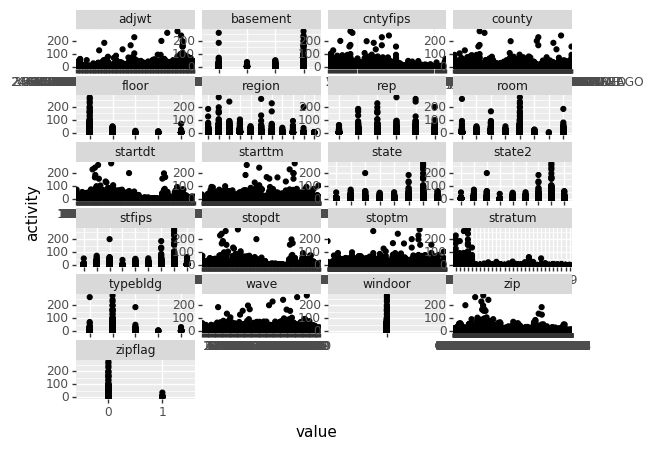

<ggplot: (-9223371894306842392)>

In [6]:
# scatter plot all features & calculate correlation with label
from plotnine import ggplot, geom_bar, geom_point, geom_text, geom_histogram, aes, facet_wrap, geom_jitter, geom_violin, coord_flip

labelcol = 'activity'

ggplot(data.melt(id_vars=labelcol)) \
+ geom_point(aes(x='value', y=labelcol)) \
+ facet_wrap(('variable'), scales="free", ncol=4)

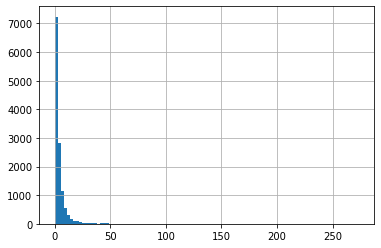

In [7]:
data[labelcol].hist(bins=100)

Feature encoding

In [8]:
# choose these features to encode
features_onehot = ['state', 'region', 'typebldg', 'basement']
features_numerical = ['floor', 'stoptm', 'stfips', 'stratum', 'room']
features_ordinal = ['county']

# feature encoding
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numerical_encoder = StandardScaler() # scale numerical columns
# normalise, standardise, log scale?
data_enc = pd.DataFrame(numerical_encoder.fit_transform(data[features_numerical]), columns=features_numerical)

onehot_encoded = pd.get_dummies(data[features_onehot])
data_enc = pd.concat((data_enc, onehot_encoded), axis=1) # one-hot encoding

ordinal_encoder = OrdinalEncoder()
ordinal_encoded = ordinal_encoder.fit_transform(data[features_ordinal])
data_enc = pd.concat((data_enc, pd.DataFrame(ordinal_encoded, columns=features_ordinal)), axis=1) # one-hot encoding

data_enc

,floor,stoptm,stfips,stratum,room,region,typebldg,state_AZ,state_IN,state_MA,state_MN,state_MO,state_ND,state_PA,state_R5,basement_,basement_0,basement_N,basement_Y,county
0,0.348714,-0.620104,-1.909837,-0.589181,-0.575083,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
1,6.184367,-1.433604,-1.909837,-0.589181,-1.696548,1,0,1,0,0,0,0,0,0,0,1,0,0,0,8.0
2,0.348714,-0.528586,-1.909837,-0.589181,-0.014351,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
3,0.348714,1.006895,-1.909837,-0.589181,-0.014351,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
4,0.348714,-1.026854,-1.909837,-0.589181,-1.135815,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12772,-0.380742,-1.026854,2.124478,5.753240,0.546382,4,1,0,0,0,0,0,0,0,1,0,0,0,1,377.0
12773,0.348714,0.427277,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,1,0,377.0
12774,0.348714,-1.169217,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,0,1,377.0
12775,0.348714,-1.372591,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,1,0,377.0


Model training: classifier with equal balance of classes

In [10]:
labels = data[labelcol].values
labels_binary = [1 if l>10 else 0 for l in labels] # make binary class labels

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/trial, best loss: -0.773776]
[20:40:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse-mean-rmse:0.40228	eval-rmse-mean-rmse:0.40402
[10]	train-rmse-mean-rmse:0.27524	eval-rmse-mean-rmse:0.28249
[20]	train-rmse-mean-rmse:0.27385	eval-rmse-mean-rmse:0.28127
[30]	train-rmse-mean-rmse:0.27318	eval-rmse-mean-rmse:0.28068
[40]	train-rmse-mean-rmse:0.27277	eval-rmse-mean-rmse:0.28021
[50]	train-rmse-mean-rmse:0.27249	eval-rmse-mean-rmse:0.27994
[60]	train-r

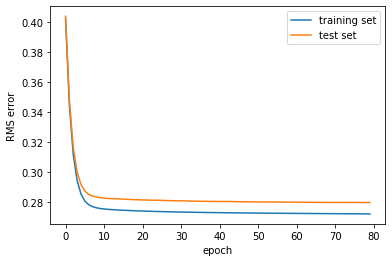

0.7683106310822501


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


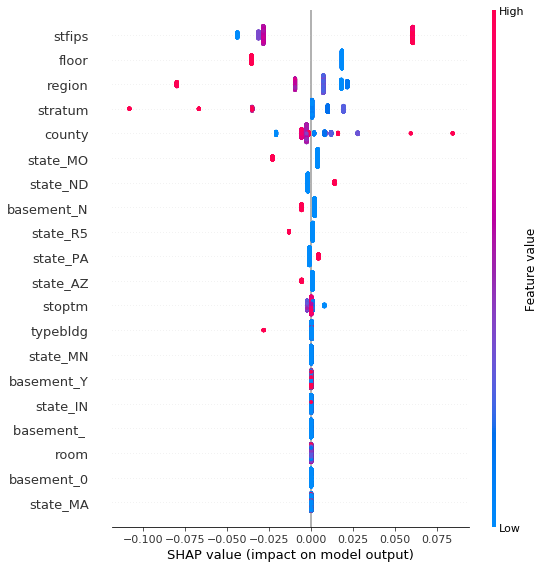

In [12]:
# XGBoost
X_train, X_test, y_train, y_test = train_test_split(data_enc.to_numpy(), np.array(labels_binary), test_size=0.2)

trainmatrix, testmatrix = xgboost.DMatrix(X_train, label=y_train), xgboost.DMatrix(X_test, label=y_test)

# optimise hyperparameters
def optimise(*args):
    colsample, lr, max_depth = args[0]
    params = {'colsample_bytree': colsample, 'learning_rate': lr, 'max_depth': max_depth}
    return -optimfct(params)
            
def optimfct(params, metric='auc', plot_loss=False):
    epochs = 80
    progress = {}
    if plot_loss: watchlist  = [(trainmatrix,'train-rmse-mean'), (testmatrix, 'eval-rmse-mean')]
    cv_results = xgboost.cv(params, trainmatrix, num_boost_round=epochs,
                            nfold=5, stratified=True, metrics={metric},
                            early_stopping_rounds=10
                           )
    
    return cv_results['test-'+metric+'-mean'].max()

# define hyperparameter search space
space = [hp.uniform('colsample_bytree', 0.5, 1.0), 
         hp.loguniform('lr', -3.5*np.log(10), 0*np.log(10)), 
         hp.choice('max_depth', range(3, 9))]

best_params = fmin(fn=optimise, space=space, algo=tpe.suggest, max_evals=100)

# train model with optimal parameters
epochs = 80
progress = {}
watchlist  = [(trainmatrix,'train-rmse-mean'), (testmatrix, 'eval-rmse-mean')]
model = xgboost.train(best_params, trainmatrix, epochs, evals=watchlist, evals_result=progress, verbose_eval=10)

# plot training performance
plt.plot(range(len(progress['train']['rmse-mean-rmse'])), progress['train']['rmse-mean-rmse'], label='training set')
plt.plot(range(len(progress['eval']['rmse-mean-rmse'])),  progress['eval']['rmse-mean-rmse'],  label='test set')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("RMS error")
plt.show()

print(roc_auc_score(y_test, model.predict(xgboost.DMatrix(X_test))))

# explain using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_train)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=data_enc.columns, max_display=50)

In [13]:
# get top features and only select those for a NN
top_feature_ids = np.argsort(np.mean(shap_values, axis=0))[::-1][:15]
top_feature_ids

array([ 0,  2, 12, 17,  3,  7,  1, 18,  4,  8,  9, 10, 15, 16, 13],
      dtype=int64)

(10221, 15) (2556, 15)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 80us/sample - loss: 0.0419 - val_loss: 0.0341
Epoch 2/40
10221/10221 [==============================] - 0s 30us/sample - loss: 0.0352 - val_loss: 0.0328
Epoch 3/40
10221/10221 [==============================] - 0s 37us/sample - loss: 0.0347 - val_loss: 0.0336
Epoch 4/40
10221/10221 [==============================] - 0s 34us/sample - loss: 0.0342 - val_loss: 0.0322
Epoch 5/40
10221/10221 [==============================] - 0s 33us/sample - loss: 0.0337 - val_loss: 0.0324
Epoch 6/40
10221/10221 [==============================] - 0s 33us/sample - loss: 0.0343 - val_loss: 0.0327
Epoch 7/40
10221/10221 [==============================] - 0s 34us/sample - loss: 0.0335 - val_loss: 0.0326
Epoch 8/40
10221/10221 [==============================] - 0s 31us/sample - loss: 0.0345 - val_loss: 0.0321
Epoch 9/40
10221/10221

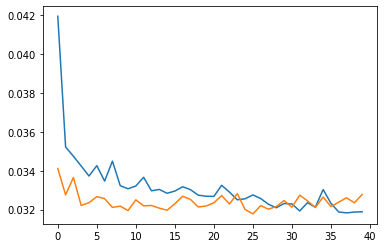

0.7504810720203086


In [14]:
# CNN
X = data_enc.to_numpy()
X = X[:, top_feature_ids]
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels_binary), test_size=0.2)
print(X_train.shape, X_test.shape)

model = tf.keras.Sequential([
    layers.Reshape((X.shape[1],1), input_shape=(X.shape[1],)),
    layers.Conv1D(64, 5, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(32, 5, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

weights = {1:1-sum(labels_binary)/len(labels_binary), 0: sum(labels_binary)/len(labels_binary)}

#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, verbose=1)
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, class_weight=weights, batch_size=300, callbacks=[])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print(roc_auc_score(y_test, model.predict(X_test)))

In [15]:
# explain using SHAP
inds = np.random.choice(X_train.shape[0], 10, replace=False)
explainer = shap.DeepExplainer(model, X_train[inds, :])
shap_values = explainer.shap_values(X_test)

Using TensorFlow backend.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



keras is no longer supported, please use tf.keras instead.


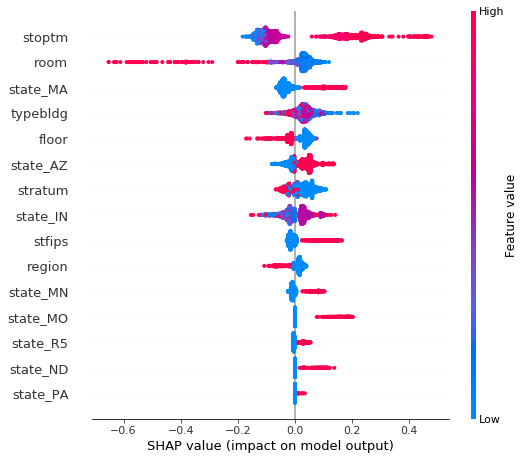

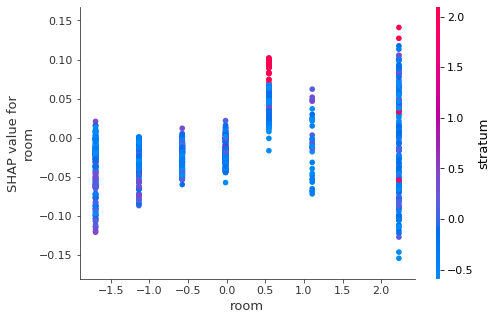

In [19]:
featurenames = data_enc.columns[top_feature_ids]
shap.summary_plot(shap_values[0], X_test, feature_names=data_enc.columns, plot_type="dot", max_display=50)
shap.dependence_plot('room', shap_values[0], X_test, dot_size=32, feature_names=featurenames)
shap.force_plot(explainer.expected_value.numpy(), shap_values[0][0], X_test[0], feature_names=featurenames)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 85us/sample - loss: 3.5452 - val_loss: 0.0823
Epoch 2/40
10221/10221 [==============================] - 0s 28us/sample - loss: 0.8366 - val_loss: 0.0531
Epoch 3/40
10221/10221 [==============================] - 0s 25us/sample - loss: 0.4129 - val_loss: 0.0566
Epoch 4/40
10221/10221 [==============================] - 0s 24us/sample - loss: 0.2758 - val_loss: 0.0833
Epoch 5/40
10221/10221 [==============================] - 0s 25us/sample - loss: 0.1943 - val_loss: 0.2168
Epoch 6/40
10221/10221 [==============================] - 0s 25us/sample - loss: 0.1512 - val_loss: 0.0712
Epoch 7/40
10221/10221 [==============================] - 0s 24us/sample - loss: 0.1284 - val_loss: 0.0426
Epoch 8/40
10221/10221 [==============================] - 0s 25us/sample - loss: 0.1009 - val_loss: 0.0385
Epoch 9/40
10221/10221 [=====================

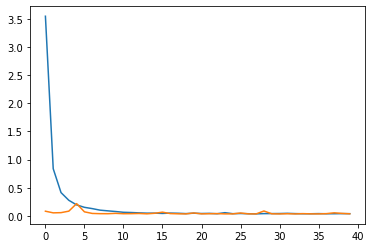

0.7471316842269663


In [20]:
# FC NN
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

weights = {1:1-sum(labels_binary)/len(labels_binary), 0: sum(labels_binary)/len(labels_binary)}

X_train, X_test, y_train, y_test = train_test_split(data_enc.to_numpy(), np.array(labels_binary), test_size=0.2)

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, class_weight=weights, batch_size=100)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print(roc_auc_score(y_test, model.predict(X_test)))

In [21]:
# for ordinal features, invert transformation and plot (global) SHAP values

# for one-hot encoded features, collect all matching columns and plot (global) SHAP values

Train regressor (transform label using nonlinear transformation, e.g. log)

(array([  90.,    0.,  304.,  884., 3657., 4448., 2617.,  649.,  113.,
          15.]),
 array([-4.60517019, -3.58351935, -2.56186851, -1.54021767, -0.51856684,
         0.503084  ,  1.52473484,  2.54638567,  3.56803651,  4.58968735,
         5.61133818]),
 <a list of 10 Patch objects>)

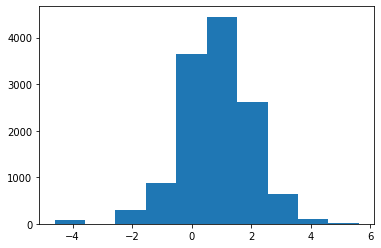

In [22]:
plt.hist(np.log(np.array(labels)+0.01))

(10221, 15) (2556, 15)
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 65us/sample - loss: 1.4423 - val_loss: 1.1820
Epoch 2/40
10221/10221 [==============================] - 0s 27us/sample - loss: 1.1990 - val_loss: 1.1184
Epoch 3/40
10221/10221 [==============================] - 0s 28us/sample - loss: 1.1654 - val_loss: 1.1163
Epoch 4/40
10221/10221 [==============================] - 0s 28us/sample - loss: 1.1583 - val_loss: 1.0926
Epoch 5/40
10221/10221 [==============================] - 0s 28us/sample - loss: 1.1475 - val_loss: 1.0906
Epoch 6/40
10221/10221 [==============================] - 0s 29us/sample - loss: 1.1415 - val_loss: 1.0833
Epoch 7/40
10221/10221 [==============================] - 0s 31us/sample - loss: 1.1413 - val_loss: 1.0812
Epoch 8/40
10221/10221 [==============================] - 0s 34us/sample - loss: 1.1420 - val_loss: 1.0946
Epoch 9/40
10221/10221 [==============================] - 0s 37us/sample

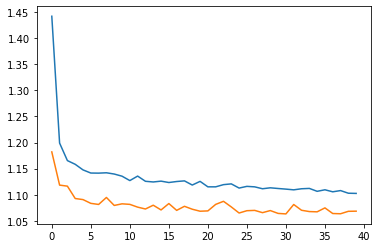

0.4901991586659477


In [24]:
model = tf.keras.Sequential([
    layers.Reshape((15,1), input_shape=(15,)),
    layers.Conv1D(64, 5, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(32, 5, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

# logarithmic labels
X_train, X_test, y_train, y_test = train_test_split(X, np.log(np.array(labels)+0.01), test_size=0.2)
print(X_train.shape, X_test.shape)

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, batch_size=300, callbacks=[])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

from scipy.stats import pearsonr
ypred = model.predict(X_test)
ypred = np.array([y[0] for y in ypred]) # flatten last dimension
print(pearsonr(y_test, ypred)[0])